In [3]:
from scipy.io import wavfile
import numpy as np
from librosa import istft, stft
import mir_eval

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

# from utils import es as es
import pickle as pkl

from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank

In [4]:
data = pkl.load(open('example_spikes_sound18.pkl'))

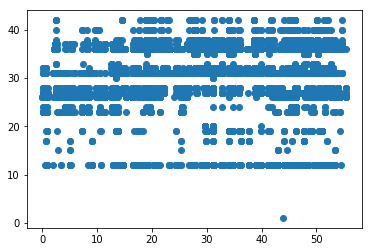

In [5]:
# plt.plot(data['ts'], data['ch'], '*')
# plt.plot(data['ts'][data['amax']==1], data['ch'][data['amax']==1], 'o')
plt.plot(data['ts'][data['amax']==8], data['ch'][data['amax']==8], 'o')


In [47]:
def wind_sp(ts, ch, w=0.001):
    ts_int = (ts // w).astype('int32')

    A = np.zeros((np.max(ts_int) + 1, max(list(set(ch))) + 1))

    for _t, _c in zip(ts_int, ch):
        A[_t, _c] += 1
    
    A = np.minimum(A, np.ones_like(A))
    return A.T

In [134]:
def exp_feat(A, win=0.05, tpe='lap', l=300):
    if tpe == 'exp':
        t = np.arange(0, win, 0.001)
        b = np.exp(-l * t)
    elif tpe == 'lap':
        t = np.arange(-win, win, 0.001)
        b = np.exp(-l * np.abs(t))
        
    b /= np.linalg.norm(b)
    AA = np.array([np.convolve(_a, b, 'same') for _a in A])
    return AA.T

(55459, 43)
(43, 55459)


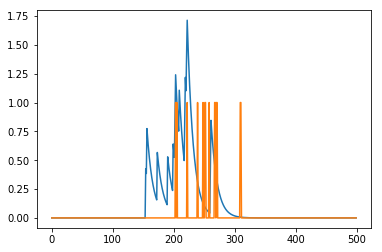

In [160]:
ts = data['ts'][data['amax']==8]
ch = data['ch'][data['amax']==8].astype('int32')

A = wind_sp(ts, ch)
X = exp_feat(A, tpe='exp', l=100, win=0.1)

print X.shape
print A.shape
# plt.imshow(AA, aspect='auto')
plt.plot(X[:500, 27])
plt.plot(A[27, :500])

In [66]:
fs = 24000
sig = data['gt1']
mfcc_feat = mfcc(sig, fs, nfft=1024)
d_mfcc_feat = delta(mfcc_feat, 2)
Y = logfbank(sig, fs, nfft=1024)


In [67]:
def simple_low_pass(X, win=25, shift=10):
    n_win = (X.shape[0] - win) // shift
    XX = np.zeros((n_win, X.shape[1]))
    for i in range(0, n_win):
        XX[i] = np.sum(X[i * shift: (i + 1) * shift] , 0) / win
    return XX

XX = simple_low_pass(X)
print XX.shape
# plt.imshow(XX, aspect='auto')

(5543, 43)


In [167]:
print X.shape
print Y.shape
x_train = X[:20000]
y_train = Y[:2000]

x_test = X[45000:50000]
y_test = Y[4500:5000]

print x_train.shape

ctx = 10 * 3
shift = 10
n_win = (x_train.shape[0] - ctx) // shift
xx_train = np.array([x_train[i:i + ctx].reshape(-1,) for i in range(0, n_win * shift, shift)])
n_win = (x_test.shape[0] - ctx) // shift
xx_test = np.array([x_test[i:i + ctx].reshape(-1,) for i in range(0, n_win * shift, shift)])

print xx_train.shape
print xx_test.shape



(55459, 43)
(5409, 26)
(20000, 43)
(1997, 1290)
(497, 1290)


In [173]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

lr = Ridge(alpha=0.1)
lr.fit(xx_train, y_train[:len(xx_train)])
y_pred = lr.predict(xx_test)
print y_pred.shape

(497, 26)


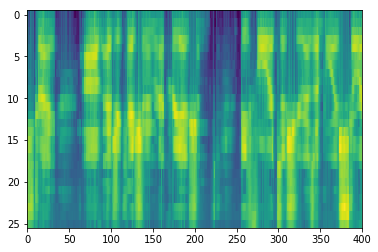

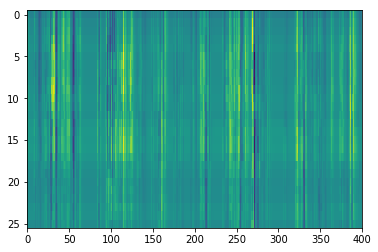

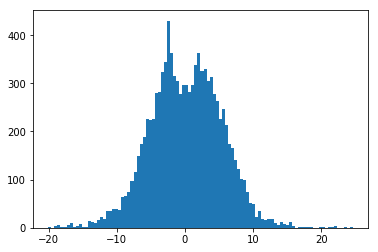

In [174]:
plt.figure()
plt.imshow(y_test.T[:, :400], aspect='auto')
plt.figure()
plt.imshow(y_pred.T[:, :400], aspect='auto')
plt.figure()
_ = plt.hist((y_train[:400] - y_pred[:400]).reshape(-1,), 100)